In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from prophet import Prophet

In [2]:
def validate_stock_data(data):
    print("\n" + "="*50)
    print("РЕЗУЛЬТАТЫ ПРОВЕРКИ ДАННЫХ")
    print("="*50)
    
    print("Пропущенные значения в колонках:")
    missing_values = data.isnull().sum()
    print(missing_values)
    
    total_missing = data.isnull().sum().sum()
    print(f"\nВсего пропущенных значений в наборе данных: {total_missing}")
    
    if total_missing > 0:
        print("ВНИМАНИЕ: Набор данных содержит пропущенные значения!")
    else:
        print("Пропущенные значения в наборе данных не найдены.")
    
    duplicates = data.duplicated().sum()
    print(f"\nДублирующиеся строки: {duplicates}")
    
    print("\nТипы данных:")
    print(data.dtypes)
    
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    infinite_values = 0
    for col in numeric_cols:
        infinite_values += np.isinf(data[col]).sum()
    print(f"\nБесконечные значения в числовых колонках: {infinite_values}")
    
    if 'Volume' in data.columns or any('Volume' in col for col in data.columns):
        volume_col = [col for col in data.columns if 'Volume' in col][0]
        negative_volumes = (data[volume_col] < 0).sum()
        print(f"\nОтрицательные значения объема: {negative_volumes}")
    
    if all(col in data.columns for col in ['Open', 'High', 'Low', 'Close']) or \
       all(any(col in multi_col for multi_col in data.columns) for col in ['Open', 'High', 'Low', 'Close']):
        
        open_col = [col for col in data.columns if 'Open' in col][0] if any('Open' in col for col in data.columns) else None
        high_col = [col for col in data.columns if 'High' in col][0] if any('High' in col for col in data.columns) else None
        low_col = [col for col in data.columns if 'Low' in col][0] if any('Low' in col for col in data.columns) else None
        close_col = [col for col in data.columns if 'Close' in col][0] if any('Close' in col for col in data.columns) else None
        
        if all(col is not None for col in [open_col, high_col, low_col, close_col]):
            inconsistencies = 0
            inconsistencies += (data[high_col] < data[low_col]).sum()
            if open_col: inconsistencies += (data[high_col] < data[open_col]).sum()
            if close_col: inconsistencies += (data[high_col] < data[close_col]).sum()
            
            print(f"Несоответствия OHLC (High < Low, Open или Close): {inconsistencies}")
    
    print("\n" + "="*50)
    return data


In [3]:
def clean_and_convert_types(data):
    print("\nВыполнение преобразования типов и очистки данных...")
    
    volume_col = [col for col in data.columns if 'Volume' in col][0]
    original_volume_type = data[volume_col].dtype
    if data[volume_col].dtype != 'int64':
        data[volume_col] = pd.to_numeric(data[volume_col], errors='coerce').astype('int64')
        print(f"Converted {volume_col} from {original_volume_type} to int64")
    else:
        print(f"{volume_col} is already int64, no conversion needed")
    
    for col in data.columns:
        if col != volume_col:
            original_col_type = data[col].dtype
            if data[col].dtype != 'float64':
                data[col] = pd.to_numeric(data[col], errors='coerce').astype('float64')
                print(f"Converted {col} from {original_col_type} to float64")
            else:
                print(f"{col} is already float64, no conversion needed")
    
    print(f"Index type: {type(data.index)}")
    print(f"Index dtype: {data.index.dtype}")
    
    print("\nТипы данных после преобразования:")
    print(data.dtypes)
    
    print("\nДополнительная проверка после преобразования:")
    
    nan_count = data.isna().sum().sum()
    print(f"Значений NaN после преобразования: {nan_count}")
    
    ohlc_cols = [col for col in data.columns if col != volume_col]
    negative_count = 0
    for col in ohlc_cols:
        neg_values = (data[col] < 0).sum()
        if neg_values > 0:
            print(f"Предупреждение: {neg_values} отрицательных значений найдено в {col}")
        negative_count += neg_values
    
    if negative_count == 0:
        print("Отрицательные значения OHLC не найдены (как и ожидалось)")
    
    print(f"\nФинальные типы данных колонок:")
    for col in data.columns:
        print(f"  {col}: {data[col].dtype}")
    
    return data


In [4]:
def prophet_anomaly_detection(data, column_name, threshold=0.95):
    print(f"\n{'='*50}")
    print(f"ОБНАРУЖЕНИЕ АНОМАЛИЙ PROPHET ДЛЯ {column_name}")
    print(f"{'='*50}")
    
    prophet_data = pd.DataFrame({
        'ds': data.index,
        'y': data[column_name].values
    })
    
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10,
        interval_width=threshold
    )
    
    model.fit(prophet_data)
    
    future = model.make_future_dataframe(periods=0)
    
    forecast = model.predict(future)
    
    result = pd.concat([
        prophet_data.set_index(prophet_data['ds']), 
        forecast.set_index(forecast['ds'])
    ], axis=1)
    
    anomalies_mask = (result['y'] < result['yhat_lower']) | (result['y'] > result['yhat_upper'])
    
    anomaly_data = result[anomalies_mask]
    
    print(f"Prophet обнаружил {len(anomaly_data)} аномалий с использованием {threshold*100}% доверительного интервала")
    
    if len(anomaly_data) > 0:
        print("Примеры дат и значений аномалий:")
        for i, (date, row) in enumerate(anomaly_data.head(10).iterrows()):
            actual_value = row['y']
            predicted_value = row['yhat']
            lower_bound = row['yhat_lower']
            upper_bound = row['yhat_upper']
            print(f"  {date.strftime('%Y-%m-%d')}: Фактическое={actual_value:.2f}, "
                  f"Предсказанное={predicted_value:.2f}, "
                  f"Границы=[{lower_bound:.2f}, {upper_bound:.2f}]")
    
    return {
        'model': model,
        'forecast': forecast,
        'anomalies_mask': anomalies_mask,
        'anomaly_data': anomaly_data,
        'result': result
    }


In [5]:
def visualize_prophet_anomalies(data, column_name, prophet_result):
    _, ax = plt.subplots(figsize=(14, 7))
    
    ax.plot(data.index, data[column_name], label='Фактические значения', color='blue', alpha=0.7)
    
    forecast_data = prophet_result['result']
    ax.plot(forecast_data.index, forecast_data['yhat'], label='Прогноз Prophet', color='red', alpha=0.7)
    
    ax.fill_between(
        forecast_data.index,
        forecast_data['yhat_lower'],
        forecast_data['yhat_upper'],
        color='red',
        alpha=0.2,
        label='Доверительный интервал'
    )
    
    anomaly_mask = prophet_result['anomalies_mask']
    if anomaly_mask.sum() > 0:
        anomaly_dates = data[anomaly_mask].index
        anomaly_values = data.loc[anomaly_mask, column_name]
        ax.scatter(
            anomaly_dates,
            anomaly_values,
            color='black',
            s=50,
            label='Аномалии (вне доверительного интервала)',
            zorder=5
        )
    
    ax.set_title(f'Обнаружение аномалий Prophet для {column_name}')
    ax.set_xlabel('Дата')
    ax.set_ylabel('Значение')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [6]:
def visualize_anomalies(data):
    close_col = [col for col in data.columns if col[0] == 'Close'][0]
    volume_col = [col for col in data.columns if col[0] == 'Volume'][0]
    
    _, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].hist(data[close_col], bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_title('Распределение цен закрытия')
    axes[0].set_xlabel('Цена закрытия ($)')
    axes[0].set_ylabel('Частота')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].hist(data[volume_col], bins=50, edgecolor='black', alpha=0.7)
    axes[1].set_title('Распределение объема')
    axes[1].set_xlabel('Объем')
    axes[1].set_ylabel('Частота')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Визуализации успешно созданы!")


In [7]:
def load_apple_stock_data():
    ticker = "AAPL"
    
    start_date = "2022-01-01"
    end_date = datetime.today().strftime('%Y-%m-%d')
    
    print(f"Загрузка данных акций {ticker} с {start_date} по {end_date}")
    
    apple_data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    
    print(f"\nФорма данных: {apple_data.shape}")
    print(f"Колонки: {list(apple_data.columns)}")
    
    print("\nПервые 5 строк:")
    print(apple_data.head())
    
    print("\nБазовая статистика:")
    print(apple_data.describe())
    
    validated_data = validate_stock_data(apple_data)
    
    cleaned_data = clean_and_convert_types(validated_data)
    
    if cleaned_data is None or cleaned_data.empty:
        print("Ошибка: cleaned_data отсутствует или пуст")
        return apple_data
    
    close_col = [col for col in cleaned_data.columns if col[0] == 'Close'][0]
    volume_col = [col for col in cleaned_data.columns if col[0] == 'Volume'][0]
    
    prophet_close_result = prophet_anomaly_detection(cleaned_data, close_col, threshold=0.95)
    
    prophet_volume_result = prophet_anomaly_detection(cleaned_data, volume_col, threshold=0.95)
    
    visualize_prophet_anomalies(cleaned_data, close_col, prophet_close_result)
    visualize_prophet_anomalies(cleaned_data, volume_col, prophet_volume_result)
    
    visualize_anomalies(cleaned_data)
    
    print("\nИнформация о данных после очистки:")
    print(cleaned_data.info())
    
    return cleaned_data


Загрузка данных акций AAPL с 2022-01-01 по 2025-11-06


[*********************100%***********************]  1 of 1 completed
02:17:43 - cmdstanpy - INFO - Chain [1] start processing



Форма данных: (964, 5)
Колонки: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]

Первые 5 строк:
Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2022-01-03  178.443146  179.296107  174.227425  174.345068  104487900
2022-01-04  176.178406  179.354917  175.609770  179.050994   99310400
2022-01-05  171.492081  176.639196  171.217569  176.090173   94537600
2022-01-06  168.629288  171.864620  168.276342  169.315567   96904000
2022-01-07  168.795929  170.727323  167.678270  169.501820   86709100

Базовая статистика:
Price        Close        High         Low        Open        Volume
Ticker        AAPL        AAPL        AAPL        AAPL          AAPL
count   964.000000  964.000000  964.000000  964.000000  9.640000e+02
mean    186.817660  188.673974  184.763510  186.627596  6.545095e+07


02:17:43 - cmdstanpy - INFO - Chain [1] done processing
02:17:43 - cmdstanpy - INFO - Chain [1] start processing
02:17:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet обнаружил 47 аномалий с использованием 95.0% доверительного интервала
Примеры дат и значений аномалий:
  2022-08-12: Фактическое=169.43, Предсказанное=153.47, Границы=[138.95, 168.10]
  2022-08-16: Фактическое=170.34, Предсказанное=155.09, Границы=[139.07, 170.11]
  2022-08-17: Фактическое=171.84, Предсказанное=155.34, Границы=[140.03, 170.09]
  2022-08-18: Фактическое=171.44, Предсказанное=155.30, Границы=[140.67, 170.88]
  2024-06-13: Фактическое=213.00, Предсказанное=196.58, Границы=[181.84, 211.83]
  2024-06-17: Фактическое=215.42, Предсказанное=198.93, Границы=[184.03, 214.94]
  2024-07-05: Фактическое=225.03, Предсказанное=208.52, Границы=[194.25, 223.30]
  2024-07-08: Фактическое=226.50, Предсказанное=210.93, Границы=[196.07, 224.88]
  2024-07-10: Фактическое=231.63, Предсказанное=211.98, Границы=[196.46, 227.07]
  2024-07-12: Фактическое=229.21, Предсказанное=213.09, Границы=[197.36, 227.98]

ОБНАРУЖЕНИЕ АНОМАЛИЙ PROPHET ДЛЯ ('Volume', 'AAPL')
Prophet обнаружил 40 анома

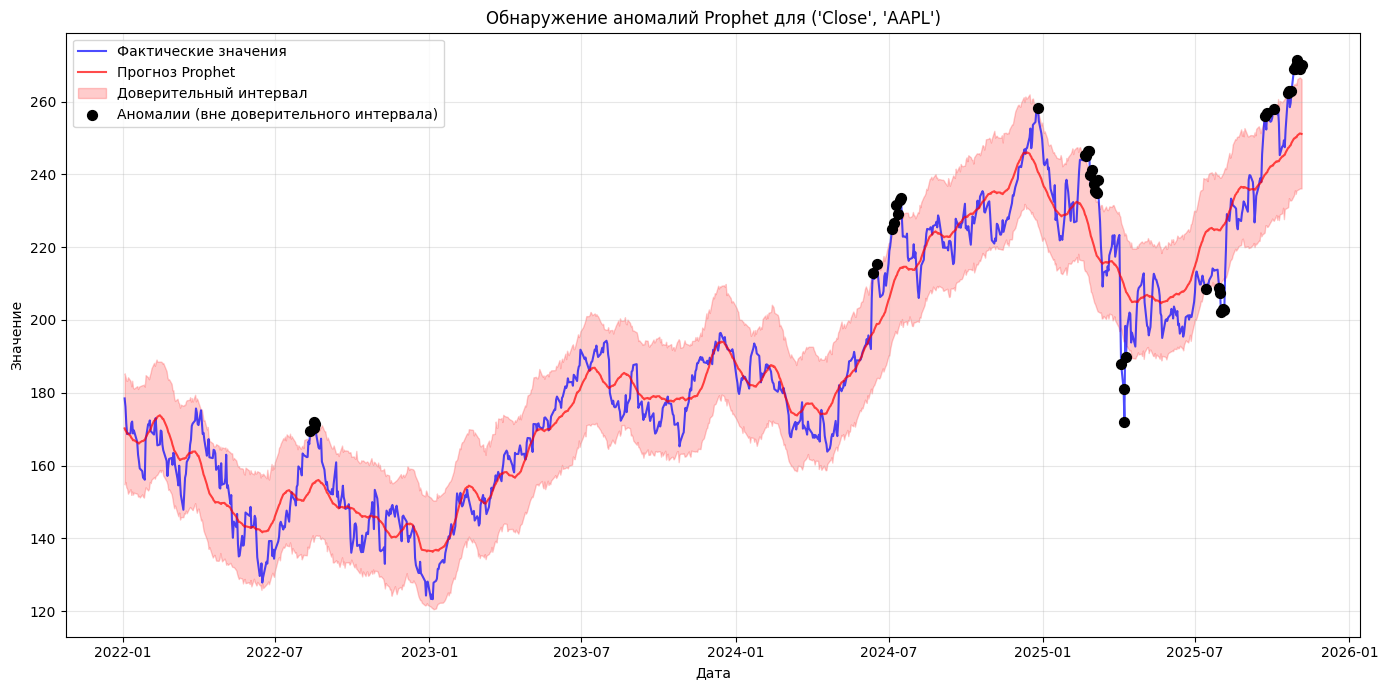

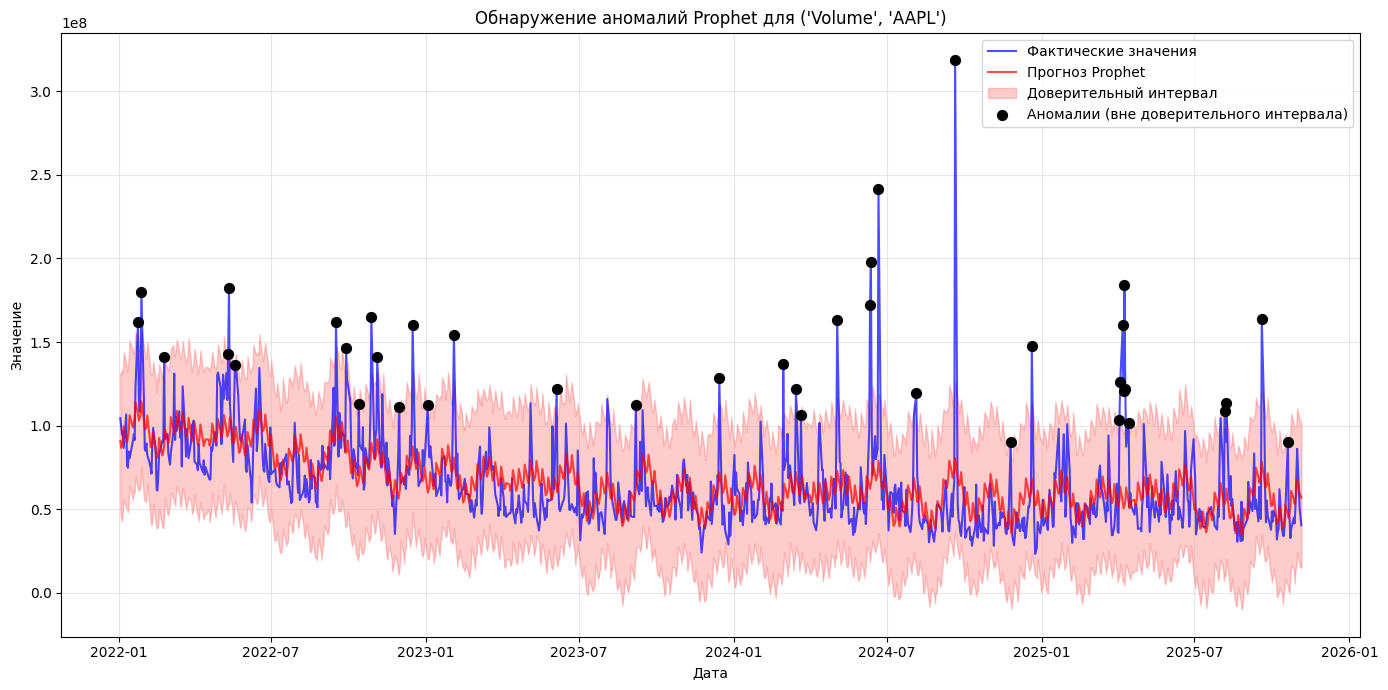

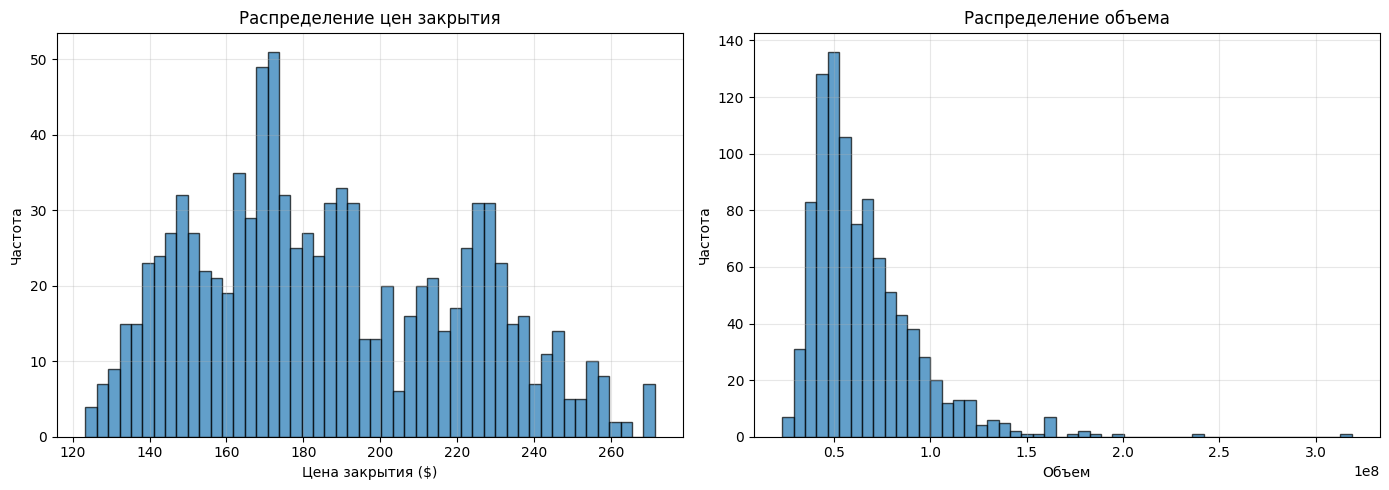

Визуализации успешно созданы!

Информация о данных после очистки:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 964 entries, 2022-01-03 to 2025-11-05
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   964 non-null    float64
 1   (High, AAPL)    964 non-null    float64
 2   (Low, AAPL)     964 non-null    float64
 3   (Open, AAPL)    964 non-null    float64
 4   (Volume, AAPL)  964 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 45.2 KB
None


In [8]:
data = load_apple_stock_data()